# Capstone Two: Data Wrangling

## 1. Introduction

The purpose of this data wrangling exercise is to ensure I have sufficient and quality data to use in developing a price prediction model. 

The dataset used in this project was obtained from https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset 
The Kaggle command API is !kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset

The definitions of the columns in the dataset are:

status = Housing status - ready for sale or, ready to build;

bed  = number of beds;

bath = number of bathrooms;

acre_lot = Property / Land size in acres;

city = name of the city where house is located;

state = name of the state;

zip_code = postal code of the area;

house_size = square footage for the house;

prev_sold_date = previous date when the house was last sold;

price = Housing price, it is either the current listing price or recently sold price if the house was sold recently.

### 1.1 Objectives

Clean the data and ensure it is sufficient to test whether house attributes such as number of bedrooms, bathrooms, as well as location and lot_size correlate with price. Also, if I can predict housing prices based on the features.

## 2. Imported Packages and Libraries

In [1]:
# Import packages and libraries
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

## 3. Load the Real Estate Data

In [2]:
# Load the original dataset
df = pd.read_csv('realtor_data.csv')

In [3]:
# Create a copy of the original dataset
df2 = df.copy()
df2.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [4]:
print(df2.shape)

(1401066, 10)


## 4. Data Definitions: Column Descriptions and Data Types

In [5]:
# An overview of the dataset: Th number of columns, rows, datatypes.
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401066 entries, 0 to 1401065
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   status          1401066 non-null  object 
 1   bed             1184538 non-null  float64
 2   bath            1206853 non-null  float64
 3   acre_lot        1043599 non-null  float64
 4   city            1400875 non-null  object 
 5   state           1401066 non-null  object 
 6   zip_code        1400587 non-null  float64
 7   house_size      950954 non-null   float64
 8   prev_sold_date  714773 non-null   object 
 9   price           1400958 non-null  float64
dtypes: float64(6), object(4)
memory usage: 106.9+ MB


In [6]:
# Counting Unique Values
df2.nunique()

status                2
bed                  48
bath                 42
acre_lot           4488
city               3512
state                19
zip_code           4220
house_size         6855
prev_sold_date    10319
price              8735
dtype: int64

In [7]:
# Percent of unique values
df2.nunique() / df2.size*100

status            0.000014
bed               0.000343
bath              0.000300
acre_lot          0.032033
city              0.025067
state             0.000136
zip_code          0.030120
house_size        0.048927
prev_sold_date    0.073651
price             0.062345
dtype: float64

In [8]:
# Convert 'zipcode' to an object
df2['zip_code'] = df2['zip_code'].astype(object)
df2['zip_code'] = df2['zip_code'].astype(str)

df2['zip_code'] = df2['zip_code'].str.replace('.0', '')

df2['zip_code'].head()

0    601
1    601
2    795
3    731
4    680
Name: zip_code, dtype: object

In [9]:
# Convert the 'prev_sold_date' to datetime
df2['prev_sold_date'] = pd.to_datetime(df2['prev_sold_date'], errors='coerce')
df2['prev_sold_date'].head()

0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
Name: prev_sold_date, dtype: datetime64[ns]

## 5. Data Cleaning

### 5.1 Missing and NaN values

In [10]:
missing = pd.concat([df2.isna().sum(), 100 * df2.isna().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
prev_sold_date,686293,48.983631
house_size,450112,32.126395
acre_lot,357467,25.513930
bed,216528,15.454518
bath,194213,13.861802
city,191,0.013632
price,108,0.007708
status,0,0.000000
state,0,0.000000
zip_code,0,0.000000


In [11]:
# Select only numeric columns
numeric_df = df2.select_dtypes(include=[np.number])

# Check for inf and -inf values
has_inf = np.isinf(numeric_df).values.any()
print(f"DataFrame contains infinite values: {has_inf}")

DataFrame contains infinite values: False


The prev_sold_date feature has the highest number of missing values. This feature does not play an important role in meeting this project's objective but I would not drop the rows for now because they may contain other useful data. Other features like the house_size, acre_lot, bed, and bath are missing about 32%, 26%, 15%, and 14% of data respectively. I will impute them with either the median, mode or mean since small percentages of data are missing.

Drop the data entries of zero or NaN in the 'price' column. The price of zero on a house would seem to be an obvious error in data entry. NaN rows were dropped because they were very few and the remaining data is sufficient to meet the set goal.

In [12]:
# Count the number of values in the 'price' column that are either 0, 0.0 or NaN
price_zero_or_nan = df2['price'].isin([0, 0.0, np.nan]).sum()

print(f"Number of values in the 'price' column that are either 0.0 or NaN:", price_zero_or_nan)

Number of values in the 'price' column that are either 0.0 or NaN: 215


In [13]:
# Drop rows with 0, 0.0, or NaN in the 'price' column
df2 = df2[(df2['price'] != 0) & (df2['price'] != 0.0) & ~df2['price'].isna()]

# Reset index after dropping rows
df2.reset_index(drop=True, inplace=True)

#Display results
print(df2.shape)

(1400851, 10)


The column with the date when a house was previously sold has a lot missing data. I would not want to drop theses values because it may contain other useful data.

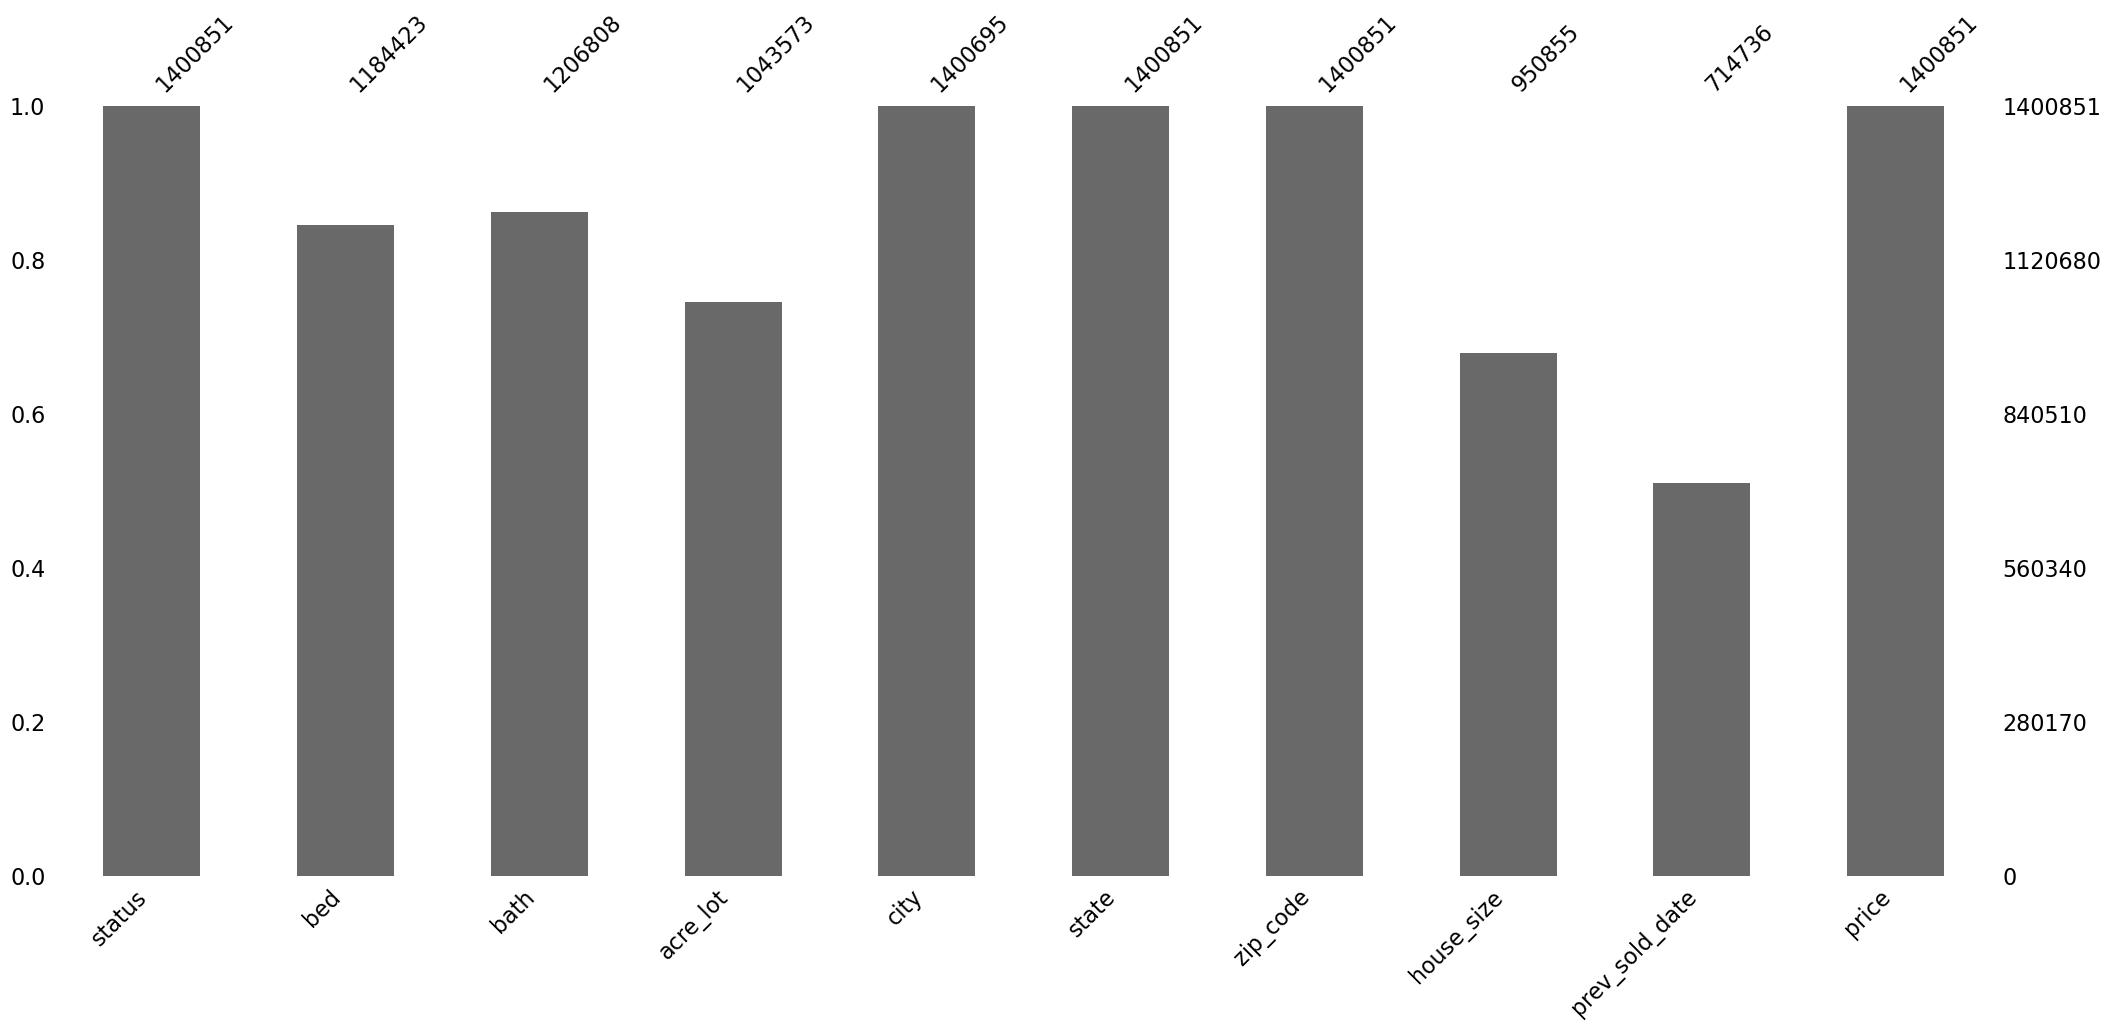

In [14]:
msno.bar(df2);

### 5.2 Handling Duplicate Rows

In [15]:
duplicate_df2 = df2[df2.duplicated(subset=["bed", "bath", "acre_lot", "city", "state", "zip_code", "house_size", "price"])]
duplicate_df2

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
77,for_sale,NaN,NaN,0.21,Aguada,Puerto Rico,602,NaN,NaT,74000.0
135,for_sale,3.0,2.0,0.08,Ponce,Puerto Rico,728,1500.0,NaT,105000.0
139,for_sale,5.0,3.0,7.46,Las Marias,Puerto Rico,670,5403.0,NaT,300000.0
140,for_sale,3.0,2.0,0.10,Lares,Puerto Rico,669,4161.0,NaT,155000.0
148,for_sale,3.0,2.0,0.05,Yauco,Puerto Rico,698,1118.0,NaT,122500.0
...,...,...,...,...,...,...,...,...,...,...
1400845,for_sale,3.0,1.0,0.10,Dunkirk,New York,14048,1002.0,2017-04-03,29900.0
1400846,for_sale,NaN,NaN,155.00,Perrysburg,New York,14129,NaN,NaT,325000.0
1400847,for_sale,4.0,2.0,0.36,Silver Creek,New York,14136,2026.0,2000-09-01,187900.0
1400849,for_sale,2.0,2.0,0.14,Dunkirk,New York,14048,1568.0,2003-04-15,92000.0


In [16]:
df2.drop_duplicates(subset=["bed", "bath", "acre_lot", "city", "state", "zip_code", "house_size", "price"], inplace=True)

print(df2.shape)

(150930, 10)


In [17]:
df2.describe().T

,count,mean,min,25%,50%,75%,max,std
bed,125904.0,3.381974,1.0,2.0,3.0,4.0,123.0,1.884592
bath,127537.0,2.504418,1.0,2.0,2.0,3.0,198.0,1.708564
acre_lot,114685.0,26.428146,0.0,0.11,0.28,1.18,100000.0,1128.774713
house_size,102241.0,2165.275995,4.0,1176.0,1690.0,2497.0,1450112.0,5303.762726
prev_sold_date,78681,2009-09-09 16:13:55.657909504,1901-01-01 00:00:00,2003-09-04 00:00:00,2011-08-03 00:00:00,2018-03-02 00:00:00,2023-03-01 00:00:00,NaN
price,150930.0,859501.384463,1.0,225000.0,425000.0,785000.0,875000000.0,3106674.19128


## 5. Conclusion

I would like to drop or impute the remaining missing values on bed, bath, acre_lot, and house_size. Deciding what to do (drop or impute) right now is immature. I would wait to do some extensive exploratory data analysis to gain a better understanding of the data. Now, I would save the dataframe as a csv.


Visualizing relationships (scatter matrix):


<Figure size 1000x600 with 0 Axes>

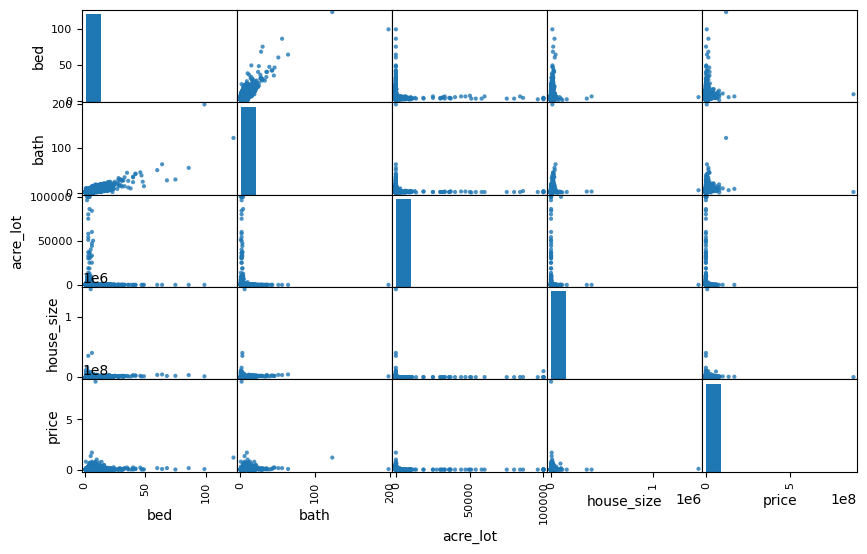

In [18]:
print("\nVisualizing relationships (scatter matrix):")
plt.figure(figsize=(10, 6))
pd.plotting.scatter_matrix(df2, alpha=0.8, figsize=(10, 6), diagonal='hist')
plt.show();

In [19]:
# Saving data as a csv in a jupyter notebook
df2.to_csv('wrangled_real_estate_data.csv', index=False)